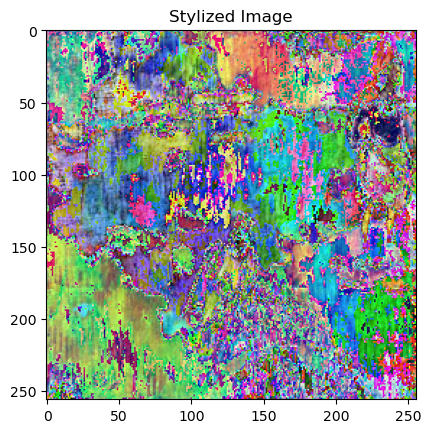

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import random
import os
import matplotlib.pyplot as plt

# Функция для загрузки изображения и изменения его размера
def load_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  # Добавляем размерность для батча

# Функция для случайного выбора изображения из папки
def get_random_image_path(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    if len(files) == 0:
        raise ValueError(f"No image files found in the directory: {folder_path}")
    random_file = random.choice(files)
    return os.path.join(folder_path, random_file)

# Функция для вычисления Грама
def gram_matrix(tensor):
    # Получаем размеры тензора
    b, c, h, w = tensor.size()
    tensor = tensor.view(b, c, h * w)
    gram = torch.bmm(tensor, tensor.transpose(1, 2))  # Грам-матрица
    gram = gram / (c * h * w)  # Нормализация
    return gram

# Функция потерь для стиля
def style_loss(output, style_image):
    gram_target = gram_matrix(output)
    gram_style = gram_matrix(style_image)
    return nn.functional.mse_loss(gram_target, gram_style)

# Основная функция для переноса стиля
def run_style_transfer(content_image_path, style_image_path, num_steps=300, style_weight=1000000, content_weight=1):
    # Загрузим контентное и стилевое изображение
    content_image = load_image(content_image_path)
    style_image = load_image(style_image_path)

    # Загрузим предобученную модель
    vgg = models.vgg19(pretrained=True).features.eval()

    # Перемещение изображений на устройство (если доступен GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content_image = content_image.to(device)
    style_image = style_image.to(device)
    vgg = vgg.to(device)

    # Инициализация изображения для оптимизации
    generated_image = content_image.clone().requires_grad_(True)

    optimizer = optim.LBFGS([generated_image])  # Используем оптимизатор L-BFGS

    # Переменная для хранения потерь
    run = [0]

    def closure():
        optimizer.zero_grad()
        
        # Прогоняем изображение через VGG
        generated_features = vgg(generated_image)
        content_features = vgg(content_image)
        style_features = vgg(style_image)

        # Потери контента
        content_loss_value = content_weight * nn.functional.mse_loss(generated_features, content_features)

        # Потери стиля
        style_loss_value = style_loss(generated_features, style_features) * style_weight
        
        # Суммируем потери
        total_loss = content_loss_value + style_loss_value
        total_loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}: Total loss {total_loss.item()}")

        return total_loss

    # Обучение
    optimizer.step(closure)

    return generated_image.detach()

# Путь к папкам с изображениями
content_folder = r"C:\Users\user\Downloads\datasets\impressionist\training\training"
style_folder = r"C:\Users\user\Downloads\datasets\impressionist\validation\validation"

# Получаем случайные изображения
try:
    content_image_path = get_random_image_path(content_folder)
    style_image_path = get_random_image_path(style_folder)

    # Выполняем перенос стиля
    output = run_style_transfer(content_image_path, style_image_path)

    # Отображаем результат
    output_image = transforms.ToPILImage()(output.squeeze(0).cpu())  # Преобразуем обратно в изображение
    plt.imshow(output_image)
    plt.title("Stylized Image")
    plt.show()

except ValueError as e:
    print(e)

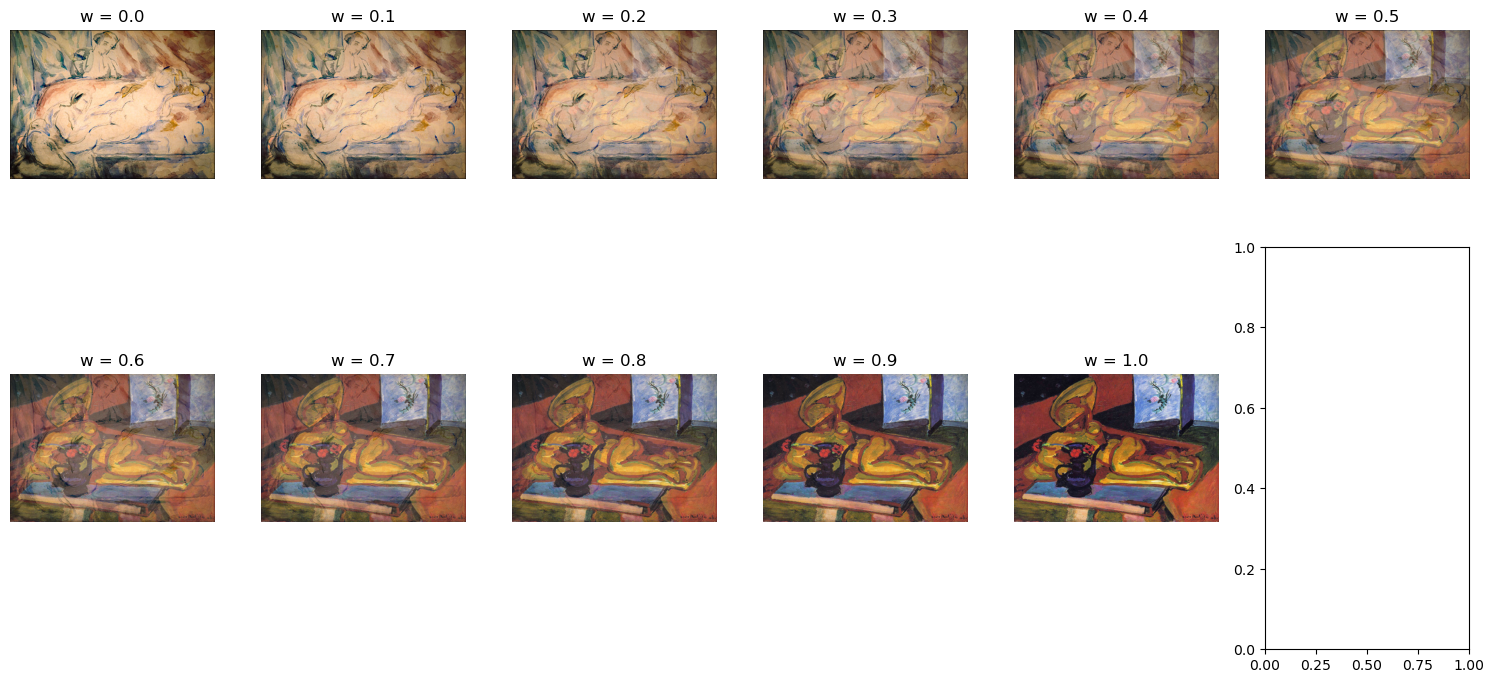

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Функция для смешивания двух изображений с весом w
def blend_images(img1, img2, w):
    # Убедитесь, что изображения одинакового размера
    img1 = np.array(img1)
    img2 = np.array(img2)
    
    # Выполняем линейную интерполяцию
    blended_img = (1 - w) * img1 + w * img2
    return Image.fromarray(np.uint8(blended_img))

# Функция для случайного выбора изображения из папки
def random_image_from_folder(folder_path):
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random_image = random.choice(image_files)
    return Image.open(os.path.join(folder_path, random_image))

# Пути к папкам с изображениями
folder1_path = 'C:/Users/user/Downloads/datasets/impressionist/validation/validation'
folder2_path = 'C:/Users/user/Downloads/datasets/impressionist/training/training'

# Случайный выбор изображений из двух папок
image1 = random_image_from_folder(folder1_path)
image2 = random_image_from_folder(folder2_path)

# Убедитесь, что изображения одного размера
image2 = image2.resize(image1.size)

# Визуализация: смешиваем изображения для значений w от 0.0 до 1.0
w_values = np.linspace(0, 1, 11)  # Генерация значений w от 0.0 до 1.0

# Создаём субплоты для отображения смешанных изображений
fig, axes = plt.subplots(2, 6, figsize=(15, 8))
axes = axes.flatten()

for i, w in enumerate(w_values):
    blended_image = blend_images(image1, image2, w)
    axes[i].imshow(blended_image)
    axes[i].set_title(f'w = {w:.1f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()